<a href="https://colab.research.google.com/github/vitorefazevedo/VAzevedo-sharing/blob/master/Teste%20t%C3%A9cnico%20Localiza/Teste_t%C3%A9cnico_Localiza_1%C2%B0_Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio técnico Localiza

Enunciado:

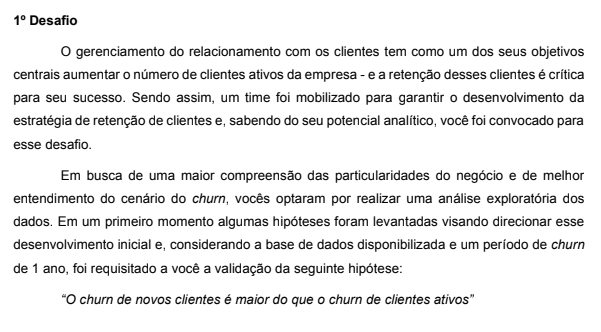

## Análise exploratória preliminar da base de dados fornecida

In [1]:
# Importação das bibliotecas utilizadas
import pandas as pd
from pandas import ExcelWriter
import numpy as np
import plotly.graph_objects as go
import plotly.figure_factory as ff
import random
import os
from plotly.subplots import make_subplots

In [2]:
# Importando a base de dados (diratamenteo do google drive)
df_raw = pd.read_excel('/content/drive/MyDrive/Data Bases/Teste técnico Localiza/base_teste_localiza.xlsx', index_col='Unnamed: 0')
df_raw.index.name = None

In [3]:
df_raw.head()

,cidade_retirada,cidade_devolucao,cd_contrato,transporte_locado,data_abertura_contrato,qtd_diarias,data_fechamento_contrato,qtd_hora_extra,cd_cliente
0,Hogsmeade,Hogsmeade,HGM048798,Portal,2015-01-26 05:58:37,1,2015-01-27 05:58:37,0,1
1,Springfield,Springfield,SPF030834,Ã”nibus Escolar,2015-02-05 15:10:19,1,2015-02-06 15:10:19,0,1
2,Porto Real,Porto Real,PRL017782,Barco,2015-05-04 20:49:56,1,2015-05-05 20:49:56,0,1
3,Basin City,Basin City,SIN042621,1960 Corvette,2015-05-07 07:34:04,1,2015-05-08 07:34:04,0,1
4,Godric's Hollow,Godric's Hollow,GDH044954,Testralio,2015-08-01 11:14:48,2,2015-08-03 12:14:48,1,1


In [4]:
# checando o tipo de dados de cada coluna e se existem valores nulos
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480863 entries, 0 to 480862
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   cidade_retirada           480863 non-null  object        
 1   cidade_devolucao          480863 non-null  object        
 2   cd_contrato               480863 non-null  object        
 3   transporte_locado         480863 non-null  object        
 4   data_abertura_contrato    480863 non-null  datetime64[ns]
 5   qtd_diarias               480863 non-null  int64         
 6   data_fechamento_contrato  480863 non-null  datetime64[ns]
 7   qtd_hora_extra            480863 non-null  int64         
 8   cd_cliente                480863 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 36.7+ MB


In [5]:
# Checando distribuições estatísticas das variáveis numéricas; média e seus valores mínimos e máximos
df_raw.describe()

,qtd_diarias,qtd_hora_extra,cd_cliente
count,480863.000000,480863.000000,480863.000000
mean,2.466301,0.110892,10208.952648
std,1.892560,0.350490,10070.974135
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2976.000000
50%,2.000000,0.000000,7145.000000
75%,3.000000,0.000000,14186.000000
max,26.000000,6.000000,123883.000000


### Primeiras impressões/conclusões:
* A base de dados não possui nenhum valor nulo.

* A base de dados não apresenta anomalias gritantes (como por exemplo valores negativos para a duração do contrato).

* Isso dispensa alguns tratamentos preliminares e nos permite seguir para etapas que nos ajudam a extrair mais contexto dessa base de dados

## Análise exploratória fenomenológica

In [6]:
print('> O primeiro contrato da base de dados foi aberto em {} \n\n> O último contrato da base de dados foi aberto em {}'
.format(df_raw['data_abertura_contrato'].min(), df_raw['data_abertura_contrato'].max()))

> O primeiro contrato da base de dados foi aberto em 2015-01-01 00:04:56 

> O último contrato da base de dados foi aberto em 2020-12-31 23:54:45


* A base possui dados do começo de 2015 até o final de 2020

In [7]:
# Atribuindo a data final a uma variável para uso futuro: 
final_data = pd.Timestamp('2020-12-31 23:59:59')

In [8]:
#@markdown Outra coisa importante de se notar é que vários clientes abrem multiplos 
#@markdown contratos sem nenhum padrão de frequência. O gráfico de disperção abaixo
#@markdown mostra os eventos de abertura de contratos para uma amostra de 5 clientes
#@markdown aleatórios:


fig = make_subplots(rows=5, cols=1,
                    shared_xaxes=True)

for i in range(1,6):
  df_raw_sample = df_raw[df_raw['cd_cliente'].isin(random.sample(list(df_raw['cd_cliente'].unique()), 1))]
  
  fig.append_trace(go.Scatter(x = df_raw_sample['data_abertura_contrato'],
                              y = df_raw_sample['cd_cliente'],
                              mode = "markers",
                              name = str(df_raw_sample.index[0])
                              ), row=i, col=1
  )

fig.update_layout(title='Amostra de clientes e suas aberturas de contratos',
                   template = 'plotly_dark',
                   xaxis=dict(title=''), 
                   yaxis=dict(title='Código do cliente'),
                   width=1200,
                   height=600
                   )

fig.update_yaxes(visible=False, showticklabels=True)

fig.show()

## Observações e discussão 


* O fato de não haver um padrão entre os contratos e todos terem uma curta duração, indica que esta base de dados muito provavelmente diz respeito ao aluguel diário para pessoas físicas.

* De acordo com o enunciado do problema precisamos analisar o *churn*, entretanto, como não se trata de um produto de renda recorrente (*i.e.* um serviço de assinatura), o conceito de *churn* não é tão direto quanto o simples término de um contrato.

* O enunciado também cita duas categorias de clientes; ativos e novos, mas não nos fornece o que define cada uma dessas categorias.

* Para progredir na resolução do problema é necessário definir o que seria considerado um *churn* nesse contexto, tal como estas duas categorias de clientes.

* Na falta de opções mais assertivas, opta-se por arbitrar tais definições e criar parâmetros dinâmicos para torná-las um pouco mais flexiveis.

### Premissas adotadas

* Todos aqueles clientes cuja última contratação ultrapassa um determinado período de tempo configuram um *churn*.

* O critério utilizado para definir se um cliente é ativo ou não será o período de tempo entre contratos, ou seja, em média, quanto tempo ele demora para abrir um novo contrato.

* Clientes obtidos a partir de determinada data serão considerados "Novos"

* OBS: Uma outra forma de definir os "novos clientes" seria considerar que "novos" são todos aqueles que "estão tendo sua primeira experiência de locação", e por tanto, só fizeram um contrato. Mas optei por não seguir esse caminho pelo fato de que clientes que fizeram apenas um contrato estão altamente correlacionados com clientes que deram *churn*, e isso resultaria em uma solução muito trivial para o problema.

In [9]:
# criando a métrica de periodo entre contratos para uso futuro:
df_raw.sort_values(['cd_cliente', 'data_abertura_contrato'], ascending = True, inplace=True)
next_contract_date = df_raw.groupby(['cd_cliente'])['data_abertura_contrato'].shift(-1)

df_raw['period_between_contracts'] = (next_contract_date - df_raw['data_abertura_contrato'])/pd.Timedelta('1 days') #a divisão pelo timedelta torna um resultado adimensional
df_raw.head()

,cidade_retirada,cidade_devolucao,cd_contrato,transporte_locado,data_abertura_contrato,qtd_diarias,data_fechamento_contrato,qtd_hora_extra,cd_cliente,period_between_contracts
0,Hogsmeade,Hogsmeade,HGM048798,Portal,2015-01-26 05:58:37,1,2015-01-27 05:58:37,0,1,10.383125
1,Springfield,Springfield,SPF030834,Ã”nibus Escolar,2015-02-05 15:10:19,1,2015-02-06 15:10:19,0,1,88.235845
2,Porto Real,Porto Real,PRL017782,Barco,2015-05-04 20:49:56,1,2015-05-05 20:49:56,0,1,2.447315
3,Basin City,Basin City,SIN042621,1960 Corvette,2015-05-07 07:34:04,1,2015-05-08 07:34:04,0,1,86.153287
4,Godric's Hollow,Godric's Hollow,GDH044954,Testralio,2015-08-01 11:14:48,2,2015-08-03 12:14:48,1,1,33.336493


In [10]:
# Agrupando a base de dados pelo código do cliente para agregar as métricas que serão utilizadas na resolução do problema.

df_agg = df_raw.groupby('cd_cliente').agg({
                                       'cd_contrato' : ['count'], 
                                       'data_abertura_contrato' : ['min', 'max'], 
                                       #'qtd_diarias' : ['sum'] , 
                                       'data_fechamento_contrato' : ['max'], 
                                       #'qtd_hora_extra' : ['sum'],
                                       'period_between_contracts': ['mean']
                                       })
df_agg.head()

cd_contrato  ... period_between_contracts
                 count  ...                     mean
cd_cliente              ...                         
1                   36  ...                59.846978
2                   43  ...                51.003146
3                   37  ...                58.010184
4                   36  ...                60.259399
5                   49  ...                44.103823

[5 rows x 5 columns]

* OBS: Apesar das demais colunas do conjunto de dados original fornecerem informações interessantes, foram omitidas pelo fato de não serem utilizadas na resolução deste problema em específico

#### Definindo os parâmetros dinâmicos para as premissas adotadas

In [11]:
#@markdown Serão considerados ativos todos aqueles clientes cujo tempo médio entre contratos é menor que

active_client_threshold =  120#@param {type:"number"}

#@markdown dias.

fig = go.Figure(data=[go.Histogram(x=df_agg[('period_between_contracts', 'mean')],
                                   showlegend=False,)])

fig.add_shape(#name = 'Limiar de clientes ativos',
              type="line",
              xref='x', yref="paper",
              x0=active_client_threshold, y0=0, x1=active_client_threshold, y1=1,
              line=dict(color="white",width=3))

fig.add_trace(go.Scatter(showlegend=False,
                         x=[active_client_threshold + 100],
                         y=[1500],
                         text=["Clientes inativos"],
                         mode="text",
))

fig.update_layout(title='Distribuição (histograma) do período médio entre contratos',
                   template = 'plotly_dark',
                   xaxis=dict(title='Período médio entre contratos', range=[0.0, 1000.0]), 
                   yaxis=dict(title='Quantidadede clientes'),
                   width=1200,
                   height=600
                   )

fig.show()

In [12]:
#@markdown Será configurado um *churn* sempre que o último contrato do cliente tiver mais de
churn_threshold = 180 #@param {type:"number"}
#@markdown Dias

churn_threshold = churn_threshold * pd.Timedelta('1 days')

#@markdown Um cliente será considerado "novo" se a abertura de seu primeiro contrato estiver em menos de
new_client_threshold = 730 #@param {type:"number"}
#@markdown Dias

new_client_threshold = new_client_threshold * pd.Timedelta('1 days')

random.seed(6)

gantt_sample = df_agg[df_agg[('cd_contrato', 'count')] > 1]

gantt_df = pd.DataFrame({'Task' : gantt_sample.index,
                         'Start': gantt_sample[('data_abertura_contrato', 'min')], 
                         'Finish': gantt_sample[('data_abertura_contrato', 'max')] }).T.to_dict().values()

fig = ff.create_gantt(random.sample(list(gantt_df), 15), 
                      #bar_width=0.5, 
                      #colors = 'Blues'
                      )

#fig.add_shape(type="line",
#              xref='x', yref="paper",
#              x0=final_data, y0=0, x1=final_data, y1=1,
#              line=dict(color="white",width=3))

fig.add_shape(type="line",
              xref='x', yref="paper",
              x0=final_data - new_client_threshold, y0=0, x1=final_data - new_client_threshold, y1=1,
              line=dict(color="blue",width=3))

fig.add_annotation(x=final_data - new_client_threshold, y=1,
                   xref='x', yref="paper",
                   text="Limiar de novos clientes",
                   showarrow=True,
                   arrowhead=1)

fig.add_shape(type="line",
              xref='x', yref="paper",
              x0=final_data - churn_threshold, y0=0, x1=final_data - churn_threshold, y1=1,
              line=dict(color="red",width=3))

fig.add_annotation(x=final_data - churn_threshold, y=1,
                   xref='x', yref="paper",
                   text="Limiar de churn",
                   showarrow=True,
                   arrowhead=1)

fig.update_layout(title='Período de atividade de uma amostra aleatória de clientes',
                   template = 'plotly_dark',
                   xaxis=dict(title=''), 
                   yaxis=dict(title='Código do cliente'),
                   width=1200,
                   height=600
                   )

fig.show()

#### O viés de borda

É importante remover da base todos os clientes obtidos após o limiar de churn, pois de acordo com o critério adotado, estes clientes necessáriamente não configurariam nenhum churn, nos fazendo subestimar o *churn rate* de novos clientes!

In [13]:
# Removendo da base clientes adquiridos muito recentemente
df_agg_cleaned = df_agg[df_agg[('data_abertura_contrato', 'min')] < final_data - churn_threshold]

## Resolução

A parte mais difícil é sem dúvidas arbitrar parâmetros e definições que façam sentido para o negócio, mas uma vez que isso é feito de maneira adequada, podemos seguir para o cálculo da proporção de *churn* pra cada categorias de clientes e validar/falsear a hipótese.

In [14]:
# Criando colunas binárias para cada uma das categorias

df_agg_cleaned['new_client'] = df_agg_cleaned[('data_abertura_contrato', 'min')] >= final_data - new_client_threshold
df_agg_cleaned['active_client'] = df_agg_cleaned[('period_between_contracts', 'mean')] <= active_client_threshold
df_agg_cleaned['churn'] = df_agg_cleaned[('data_abertura_contrato', 'max')] < final_data - churn_threshold

In [15]:
#percentual de novos clientes, clientes ativos e churn rate total
df_agg_cleaned[df_agg_cleaned.columns[-3::]].mean()

new_client         0.073833
active_client      0.252544
churn              0.566906
dtype: float64

In [16]:
#@markdown ###Resultado:
new_client_churn_rate = df_agg_cleaned[df_agg_cleaned['new_client']]['churn'].mean()
active_client_churn_rate = df_agg_cleaned[df_agg_cleaned['active_client']]['churn'].mean()

if new_client_churn_rate > active_client_churn_rate:
  result = 'Confirma-se'
else:
  result = 'Rejeita-se'

print(
' - Churn rate de novos clientes: {}%\n - Churn rate de clientes ativos: {}%\n\n >>> Portanto, {} a hipótese de que “O churn de novos clientes é maior do que o churn de clientes ativos”'
.format(round(new_client_churn_rate*100, 2),
        round(active_client_churn_rate*100, 2),
        result))

 - Churn rate de novos clientes: 90.13%
 - Churn rate de clientes ativos: 17.3%

 >>> Portanto, Confirma-se a hipótese de que “O churn de novos clientes é maior do que o churn de clientes ativos”
